In [66]:
import os
import time

import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from skimage import color

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

In [39]:
class LeafDataset(Dataset):
    def __init__(self, root_dir, mode='train'):
        self.mode = mode
        self.files = []


        if mode == 'train':
            healthy_dir = os.path.join(root_dir, 'Healthy_Train50')
            if os.path.exists(healthy_dir):
                healthy_files = sorted([os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir) if f.endswith(('.jpg', '.png'))])
                self.files = healthy_files
            else:
                print(f"Diretório '{healthy_dir}', contendo folhas saudáveis de treino não foi encontrado!")
        else:
            healthy_dir = os.path.join(root_dir, 'Healthy_Test50')
            if os.path.exists(healthy_dir):
                healthy_files = sorted([os.path.join(healthy_dir, f) for f in os.listdir(healthy_dir) if f.endswith(('.jpg', '.png'))])
                self.files = healthy_files
            else:
                print(f"Diretório '{healthy_dir}', contendo folhas saudáveis de teste não foi encontrado!")
            
            disease_dir = os.path.join(root_dir, 'Disease_Test100')
            if os.path.exists(disease_dir):
                disease_files = sorted([os.path.join(disease_dir, f) for f in os.listdir(disease_dir) if f.endswith(('.jpg', '.png'))])
                self.files.extend(disease_files)
            else:
                print(f"Diretório '{disease_dir}', contendo folhas doentes de teste não foi encontrado!")

        self.transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __getitem__(self, index):
        img_path = self.files[index]
        img = Image.open(img_path).convert('RGB')

        img_color = self.transform(img)

        grayscale_transform = transforms.Grayscale(num_output_channels=3)
        img_gray = grayscale_transform(img)
        img_gray = self.transform(img_gray)

        return {"A": img_gray, "B":img_color, "C": img_path}
    
    def __len__(self):
        return len(self.files)


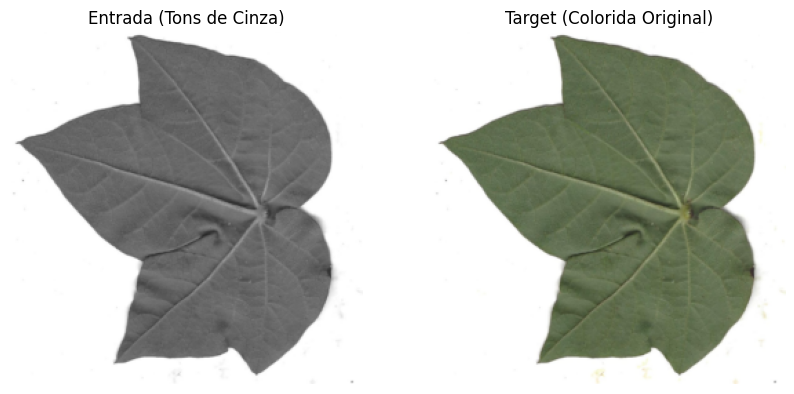

In [8]:
def tensor_to_image(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image * 0.5 + 0.5
    
    image = image.transpose(1, 2, 0)
    
    image = np.clip(image, 0, 1)
    return image

dataset = LeafDataset(root_dir='./data', mode='train')

amostra = dataset[0] 
img_input = amostra['A']
img_real = amostra['B']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Entrada (Tons de Cinza)")
plt.imshow(tensor_to_image(img_input))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Target (Colorida Original)")
plt.imshow(tensor_to_image(img_real))
plt.axis('off')

plt.show()

In [18]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=True):
        super().__init__()
        layers = []
        
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False))
        
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
            
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super().__init__()
        layers = []
        
        layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False))

        if dropout:
            layers.append(nn.Dropout2d(0.5))
            
        layers.append(nn.ReLU(inplace=True))
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = DownBlock(3, 64, batch_norm=False) 
        self.down2 = DownBlock(64, 128)
        self.down3 = DownBlock(128, 256)
        self.down4 = DownBlock(256, 512)
        self.down5 = DownBlock(512, 512)
        self.down6 = DownBlock(512, 512)
        self.down7 = DownBlock(512, 512)
        self.down8 = DownBlock(512, 512, batch_norm=False)

        self.up1 = UpBlock(512, 512, dropout=True)
        self.up2 = UpBlock(1024, 512, dropout=True)
        self.up3 = UpBlock(1024, 512, dropout=True)
        self.up4 = UpBlock(1024, 512)
        self.up5 = UpBlock(1024, 256)
        self.up6 = UpBlock(512, 128)
        self.up7 = UpBlock(256, 64)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8)
        
        u1_cat = torch.cat([u1, d7], dim=1)
        
        u2 = self.up2(u1_cat)
        u2_cat = torch.cat([u2, d6], dim=1)
        
        u3 = self.up3(u2_cat)
        u3_cat = torch.cat([u3, d5], dim=1)
        
        u4 = self.up4(u3_cat)
        u4_cat = torch.cat([u4, d4], dim=1)
        
        u5 = self.up5(u4_cat)
        u5_cat = torch.cat([u5, d3], dim=1)
        
        u6 = self.up6(u5_cat)
        u6_cat = torch.cat([u6, d2], dim=1)
        
        u7 = self.up7(u6_cat)
        u7_cat = torch.cat([u7, d1], dim=1)
        
        out = self.last(u7_cat)
        
        return out

In [26]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(6, 64, normalization=False),
            
            *discriminator_block(64, 128),
            
            *discriminator_block(128, 256),
            
            *discriminator_block(256, 512),
            
            nn.Conv2d(512, 1, kernel_size=4, padding=1) 
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)

criterion_GAN = nn.MSELoss() 
criterion_pixelwise = nn.L1Loss() 

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

lambda_pixel = 100

num_epochs = 10

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print("Iniciando treinamento...")
generator.train()

for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        
        start_time = time.time()

        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)

        optimizer_G.zero_grad()

        fake_B = generator(real_A)

        pred_fake = discriminator(real_A, fake_B)

        valid = torch.ones_like(pred_fake, requires_grad=False).to(device)
        fake = torch.zeros_like(pred_fake, requires_grad=False).to(device)
        
        loss_GAN = criterion_GAN(pred_fake, valid)

        loss_pixel = criterion_pixelwise(fake_B, real_B)

        loss_G = loss_GAN + (lambda_pixel * loss_pixel)

        loss_G.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        pred_real = discriminator(real_A, real_B)
        loss_real = criterion_GAN(pred_real, valid)

        pred_fake = discriminator(real_A, fake_B.detach())
        loss_fake = criterion_GAN(pred_fake, fake)

        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()

        batch_time = time.time() - start_time

        if i % 10 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}] "
                  f"[Time: {batch_time:.3f}s]")

Iniciando treinamento...
[Epoch 0/10] [Batch 0/13] [D loss: 0.6977] [G loss: 81.5014] [Time: 6.114s]
[Epoch 0/10] [Batch 10/13] [D loss: 0.1622] [G loss: 18.1865] [Time: 4.437s]
[Epoch 1/10] [Batch 0/13] [D loss: 0.5125] [G loss: 11.2900] [Time: 4.433s]
[Epoch 1/10] [Batch 10/13] [D loss: 0.2461] [G loss: 6.5295] [Time: 4.579s]
[Epoch 2/10] [Batch 0/13] [D loss: 0.2417] [G loss: 5.7191] [Time: 4.369s]
[Epoch 2/10] [Batch 10/13] [D loss: 0.2422] [G loss: 5.6220] [Time: 4.189s]
[Epoch 3/10] [Batch 0/13] [D loss: 0.2456] [G loss: 4.9893] [Time: 4.251s]
[Epoch 3/10] [Batch 10/13] [D loss: 0.2447] [G loss: 4.1180] [Time: 4.254s]
[Epoch 4/10] [Batch 0/13] [D loss: 0.2457] [G loss: 4.3521] [Time: 4.241s]
[Epoch 4/10] [Batch 10/13] [D loss: 0.2456] [G loss: 4.7480] [Time: 4.631s]
[Epoch 5/10] [Batch 0/13] [D loss: 0.2466] [G loss: 3.9079] [Time: 5.482s]
[Epoch 5/10] [Batch 10/13] [D loss: 0.2643] [G loss: 3.7225] [Time: 3.897s]
[Epoch 6/10] [Batch 0/13] [D loss: 0.3044] [G loss: 4.7155] [Time:

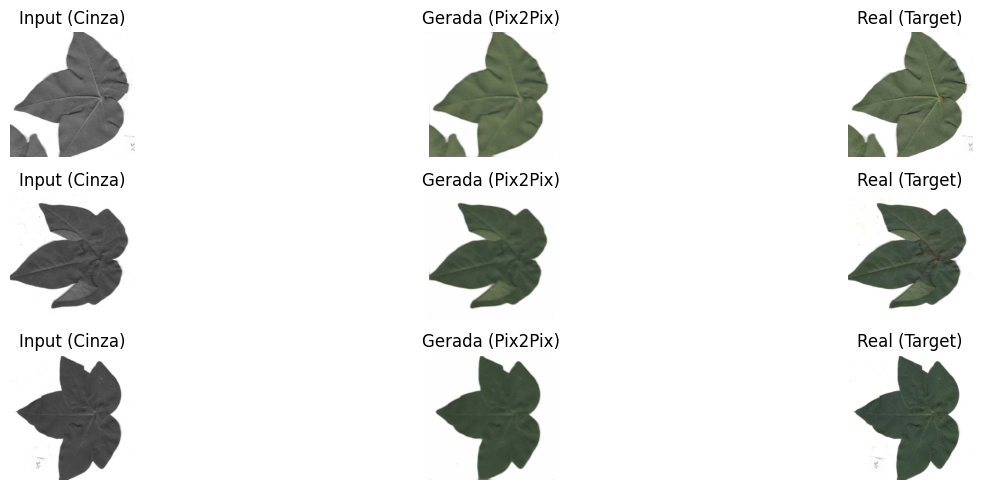

In [ ]:
generator.eval()

batch = next(iter(dataloader))
real_A = batch["A"].to(device) 
real_B = batch["B"].to(device) 

with torch.no_grad():
    fake_B = generator(real_A)

plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(tensor_to_image(real_A[i]), cmap='gray')
    plt.title("Input (Cinza)")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(tensor_to_image(fake_B[i]))
    plt.title("Gerada (Pix2Pix)")
    plt.axis('off')

    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(tensor_to_image(real_B[i]))
    plt.title("Real (Target)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [32]:
torch.save(generator.state_dict(), 'models/generator_final.pth')
torch.save(discriminator.state_dict(), 'models/discriminator_final.pth')

In [33]:
# Exemplo de como carregar (não precisa rodar agora se a rede já está na memória)
# generator = UNetGenerator().to(device)
# generator.load_state_dict(torch.load('models/generator_final.pth'))
# generator.eval() # Importante colocar em modo de avaliação

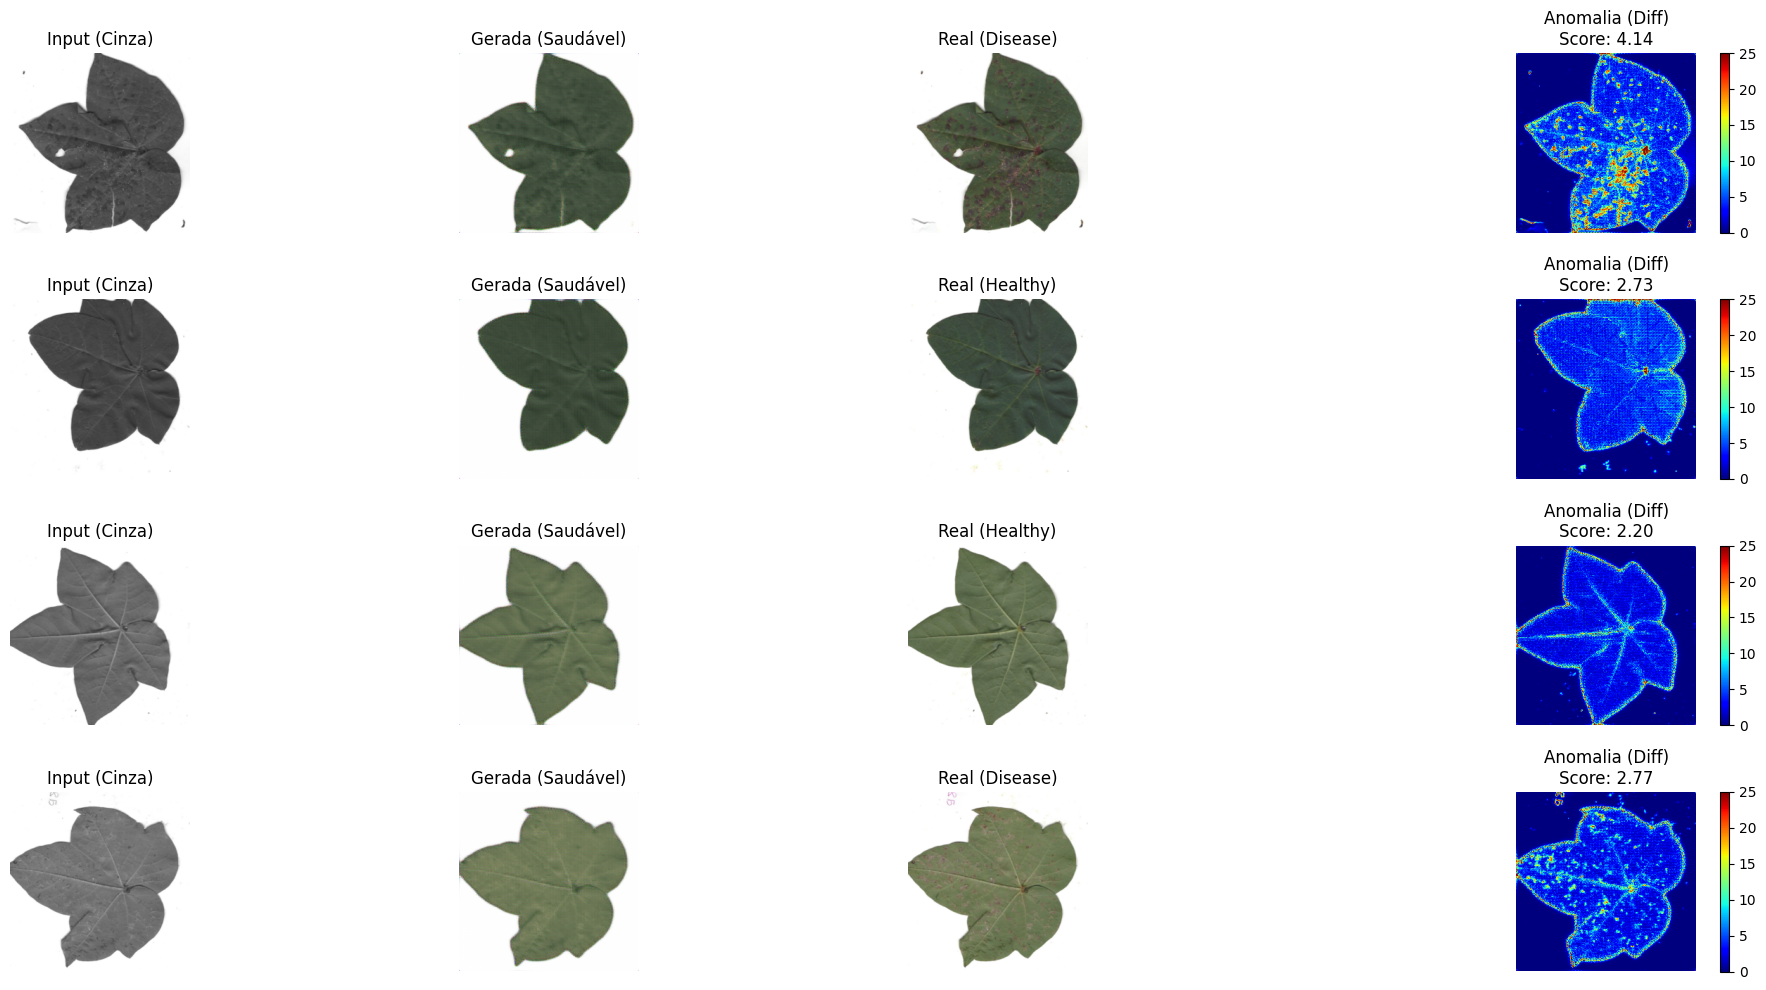

In [51]:
def calculate_anomaly_score(img_real_tensor, img_fake_tensor):
    real_np = tensor_to_image(img_real_tensor)
    fake_np = tensor_to_image(img_fake_tensor)
    
    real_lab = color.rgb2lab(real_np)
    fake_lab = color.rgb2lab(fake_np)
    
    diff_map = color.deltaE_ciede2000(real_lab, fake_lab)
    
    return diff_map

test_dataset = LeafDataset(root_dir='./data', mode='test')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

batch = next(iter(test_loader))
real_A = batch["A"].to(device)
real_B = batch["B"].to(device)
real_C = batch["C"]

generator.eval()
with torch.no_grad():
    fake_B = generator(real_A)

plt.figure(figsize=(20, 10))

for i in range(4):
    heatmap = calculate_anomaly_score(real_B[i], fake_B[i])
    
    score_total = np.mean(heatmap) 
    
    path_str = real_C[i]
    if "Disease" in path_str or "disease" in path_str:
        label = "Disease"
    else:
        label = "Healthy"

    plt.subplot(4, 4, i*4 + 1)
    plt.imshow(tensor_to_image(real_A[i]), cmap='gray')
    plt.title("Input (Cinza)")
    plt.axis('off')
    
    plt.subplot(4, 4, i*4 + 2)
    plt.imshow(tensor_to_image(fake_B[i]))
    plt.title("Gerada (Saudável)")
    plt.axis('off')

    plt.subplot(4, 4, i*4 + 3)
    plt.imshow(tensor_to_image(real_B[i]))
    plt.title(f"Real ({label})")
    plt.axis('off')

    plt.subplot(4, 4, i*4 + 4)
    
    im = plt.imshow(heatmap, cmap='jet', vmin=0, vmax=25) 
    plt.title(f"Anomalia (Diff)\nScore: {score_total:.2f}")
    plt.axis('off')
    plt.colorbar(im, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Calculando métricas no dataset de teste completo...
Processado 150 imagens.

--- Resultados ---
AUC (Area Under Curve): 0.8736
Threshold Ideal sugerido: 2.8137
Acurácia: 0.7667
Precisão: 0.9452
Recall: 0.6900
F1-Score: 0.7977


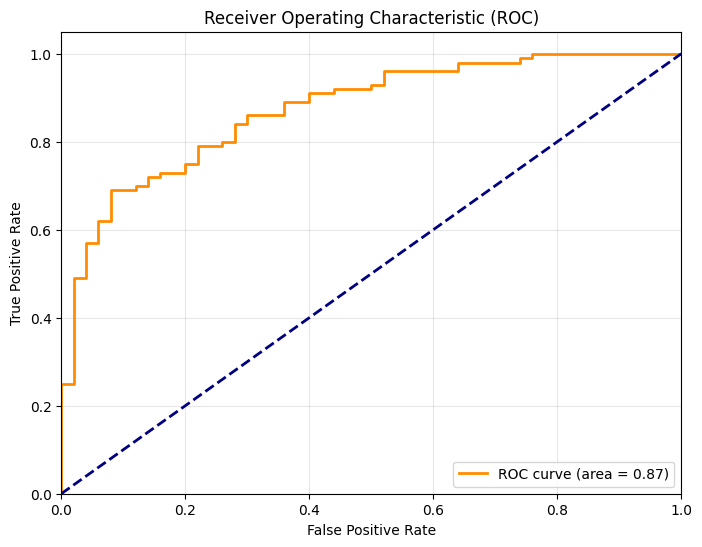

In [54]:
y_true = []   
y_scores = [] 

print("Calculando métricas no dataset de teste completo...")

generator.eval()

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        real_A = batch["A"].to(device)
        real_B = batch["B"].to(device)
        paths = batch["C"]
        
        fake_B = generator(real_A)
        
        for j in range(len(real_A)):
            path_str = paths[j]
            if "Disease" in path_str or "disease" in path_str:
                label = 1
            else:
                label = 0
            
            y_true.append(label)
            
            heatmap = calculate_anomaly_score(real_B[j], fake_B[j])
            
            score = np.mean(heatmap)
            y_scores.append(score)

print(f"Processado {len(y_scores)} imagens.")

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

print("\n--- Resultados ---")
print(f"AUC (Area Under Curve): {roc_auc:.4f}")

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Threshold Ideal sugerido: {optimal_threshold:.4f}")

y_pred = [1 if s >= optimal_threshold else 0 for s in y_scores]

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
acc = accuracy_score(y_true, y_pred)

print(f"Acurácia: {acc:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

<Figure size 800x600 with 0 Axes>

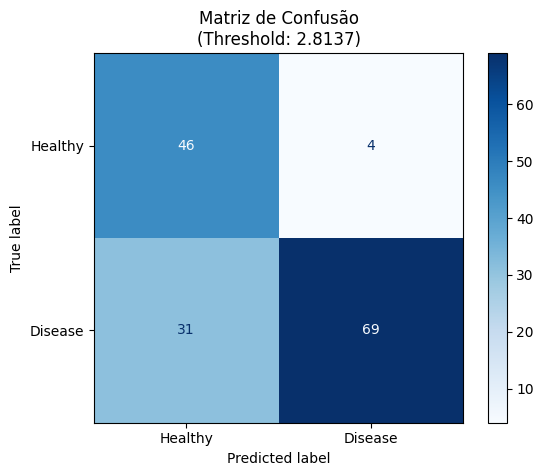

--- Detalhamento ---
Verdadeiros Negativos (Healthy classificado como Healthy): 46
Falsos Positivos (Healthy classificado como Disease): 4
Falsos Negativos (Disease classificado como Healthy): 31
Verdadeiros Positivos (Disease classificado como Disease): 69


In [56]:
cm = confusion_matrix(y_true, y_pred)

# 2. Configurar a visualização
# display_labels=['Healthy', 'Disease'] mapeia 0 -> Healthy e 1 -> Disease
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Disease'])

# 3. Plotar
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d') # 'd' para mostrar números inteiros, não notação científica
plt.title(f"Matriz de Confusão\n(Threshold: {optimal_threshold:.4f})")
plt.show()

# Extra: Printar os valores brutos para facilitar a leitura
tn, fp, fn, tp = cm.ravel()
print("--- Detalhamento ---")
print(f"Verdadeiros Negativos (Healthy classificado como Healthy): {tn}")
print(f"Falsos Positivos (Healthy classificado como Disease): {fp}")
print(f"Falsos Negativos (Disease classificado como Healthy): {fn}")
print(f"Verdadeiros Positivos (Disease classificado como Disease): {tp}")

Novo Threshold para Recall >= 0.9: 2.4642


<Figure size 800x600 with 0 Axes>

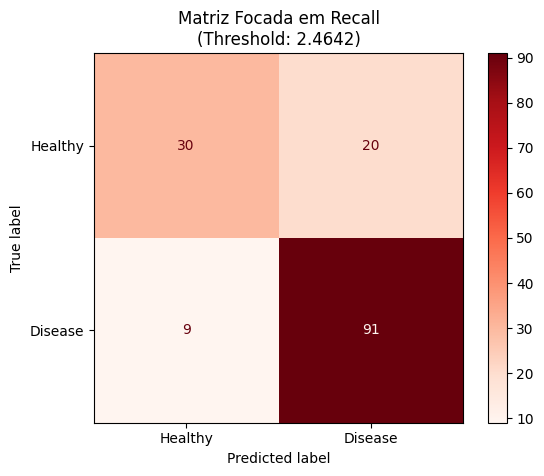

--- Novo Detalhamento ---
Falsos Negativos (Diminuiu?): 9
Falsos Positivos (Aumentou?): 20
Recall Atingido: 0.91


In [63]:
target_recall = 0.90

found_idx = next(i for i, x in enumerate(tpr) if x >= target_recall)
new_threshold = thresholds[found_idx]

print(f"Novo Threshold para Recall >= {target_recall}: {new_threshold:.4f}")

y_pred_recall = [1 if s >= new_threshold else 0 for s in y_scores]

cm_recall = confusion_matrix(y_true, y_pred_recall)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_recall, display_labels=['Healthy', 'Disease'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Reds', values_format='d')
plt.title(f"Matriz Focada em Recall\n(Threshold: {new_threshold:.4f})")
plt.show()

tn, fp, fn, tp = cm_recall.ravel()
print("--- Novo Detalhamento ---")
print(f"Falsos Negativos (Diminuiu?): {fn}")
print(f"Falsos Positivos (Aumentou?): {fp}")
print(f"Recall Atingido: {tp / (tp + fn):.2f}")

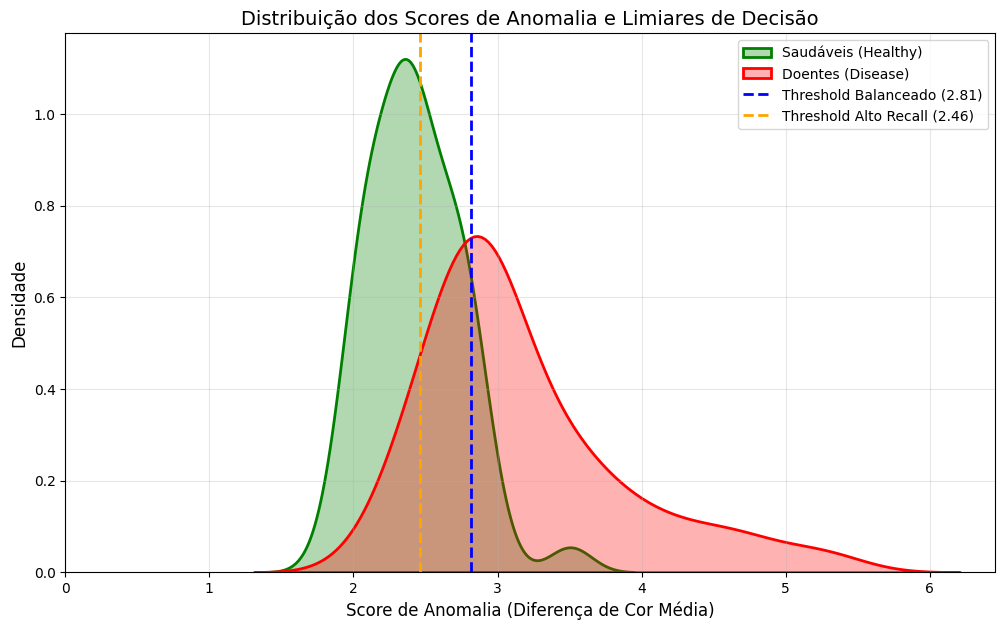

In [64]:
y_scores_np = np.array(y_scores)
y_true_np = np.array(y_true)

scores_healthy = y_scores_np[y_true_np == 0]
scores_disease = y_scores_np[y_true_np == 1]

plt.figure(figsize=(12, 7))

sns.kdeplot(scores_healthy, fill=True, color='green', alpha=0.3, 
            label='Saudáveis (Healthy)', linewidth=2)

sns.kdeplot(scores_disease, fill=True, color='red', alpha=0.3, 
            label='Doentes (Disease)', linewidth=2)

plt.axvline(optimal_threshold, color='blue', linestyle='--', linewidth=2, 
            label=f'Threshold Balanceado ({optimal_threshold:.2f})')

plt.axvline(new_threshold, color='orange', linestyle='--', linewidth=2, 
            label=f'Threshold Alto Recall ({new_threshold:.2f})')

plt.title('Distribuição dos Scores de Anomalia e Limiares de Decisão', fontsize=14)
plt.xlabel('Score de Anomalia (Diferença de Cor Média)', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.xlim(left=0)

plt.show()

In [71]:
class DiscriminatorGradCAM:
    def __init__(self, discriminator):
        self.discriminator = discriminator
        self.gradients = None
        self.activations = None
        
        target_layer = self.discriminator.model[-2] 
        
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.clone()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].clone()

    def generate_heatmap(self, img_A, img_B):
        self.discriminator.zero_grad()
        
        output = self.discriminator(img_A, img_B)
        
        score = output.mean()
        score.backward(retain_graph=True)
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        activation = self.activations.detach().clone()
        pooled_gradients = pooled_gradients.detach().clone()
        
        for i in range(activation.shape[1]):
            activation[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activation, dim=1).squeeze()
        
        heatmap = heatmap.detach().cpu().numpy()
        
        heatmap = np.maximum(heatmap, 0)
        
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
            
        return heatmap

grad_cam = DiscriminatorGradCAM(discriminator)

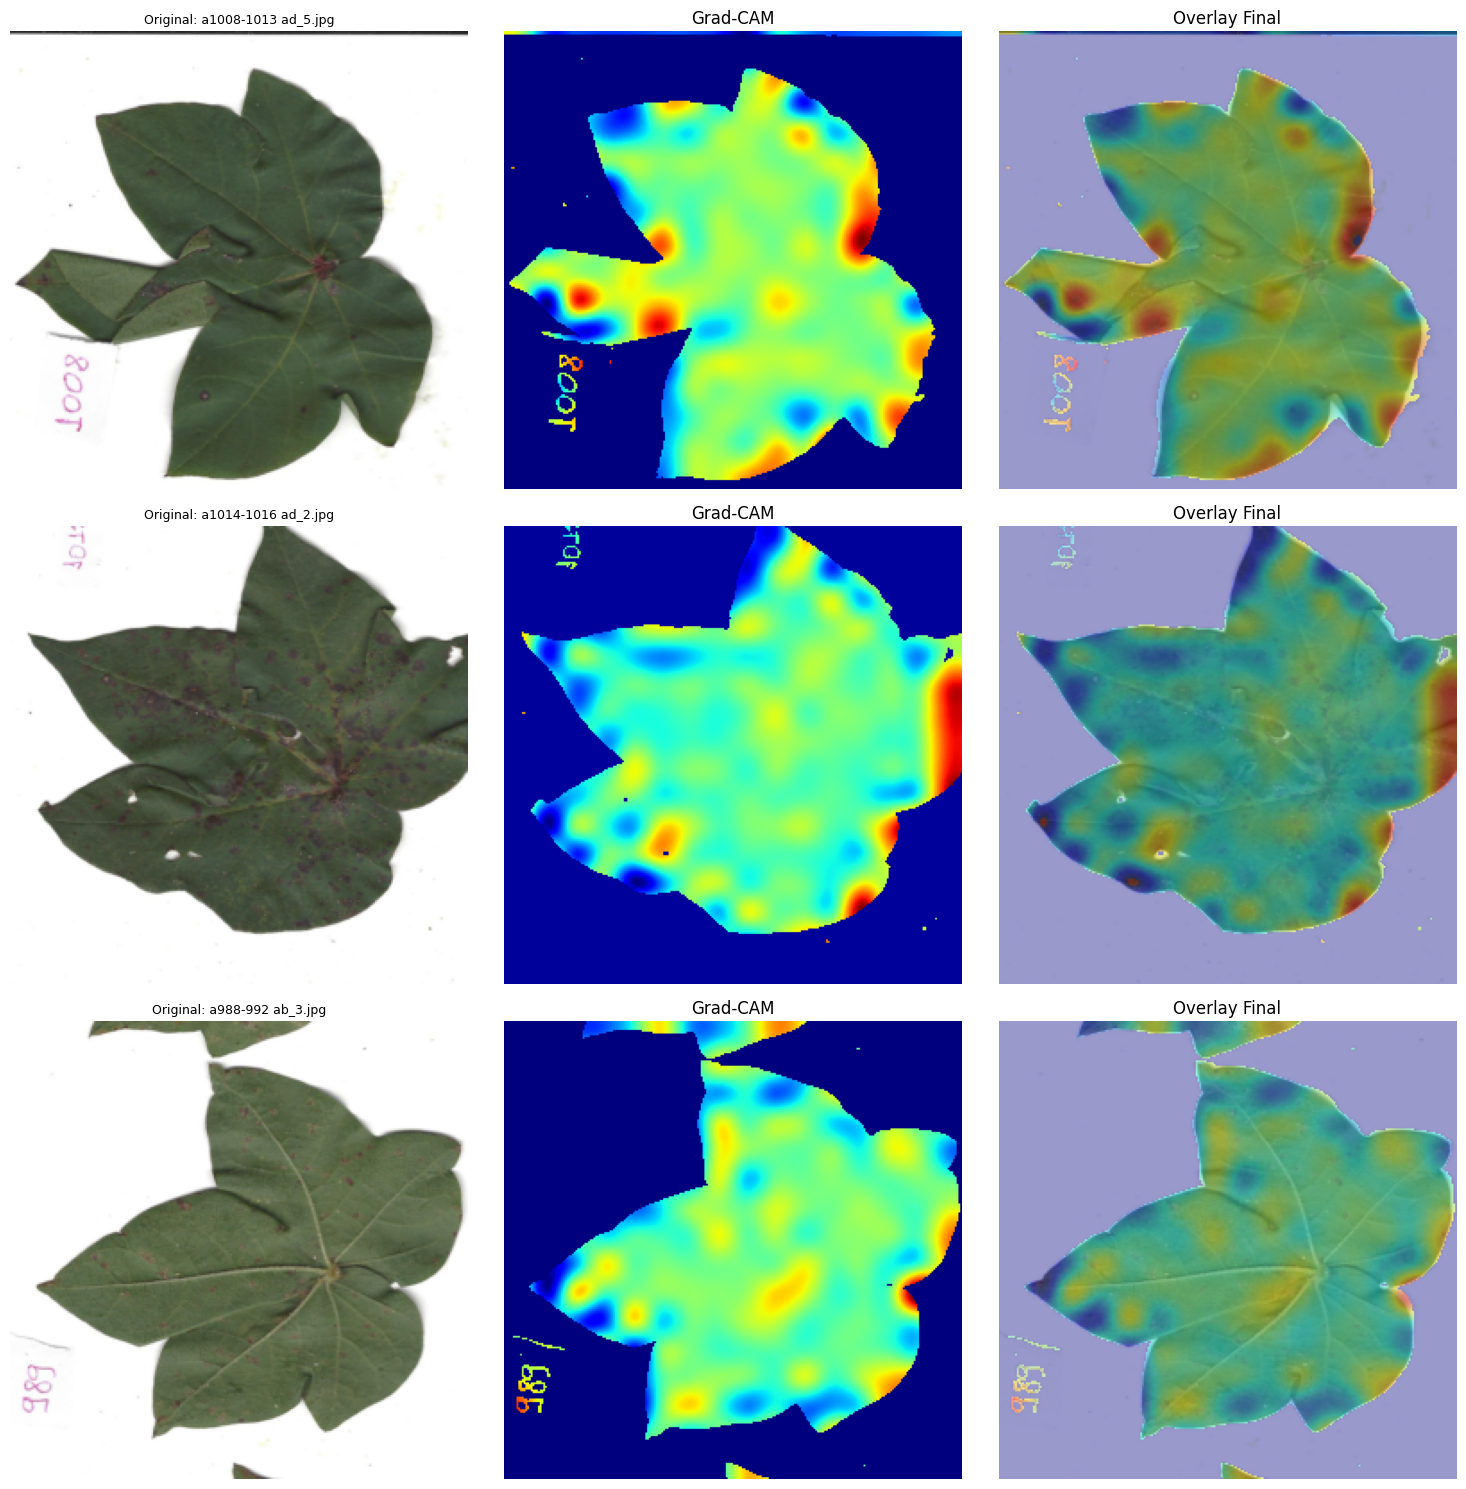

In [76]:
discriminator.eval() 

for module in discriminator.modules():
    if isinstance(module, nn.LeakyReLU):
        module.inplace = False

found_disease = False
while not found_disease:
    batch = next(iter(test_loader))
    real_A = batch["A"].to(device)
    real_B = batch["B"].to(device)
    paths = batch["C"]
    
    disease_indices = [i for i, path in enumerate(paths) if "Disease" in path or "disease" in path]
    if len(disease_indices) > 0:
        found_disease = True
        
        target_indices = disease_indices[:3]

plt.figure(figsize=(15, 5 * len(target_indices)))

for i, idx in enumerate(target_indices):
    input_gray = real_A[idx].unsqueeze(0)
    input_color = real_B[idx].unsqueeze(0)
    
    heatmap = grad_cam.generate_heatmap(input_gray, input_color)
    
    heatmap_resized = cv2.resize(heatmap, (256, 256), interpolation=cv2.INTER_CUBIC)
    
    img_original_np = tensor_to_image(real_B[idx])
    img_original_uint8 = (img_original_np * 255).astype(np.uint8)
    
    gray_original = cv2.cvtColor(img_original_uint8, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray_original, 230, 1, cv2.THRESH_BINARY_INV)
    
    heatmap_resized = heatmap_resized * mask
    
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    overlay = cv2.addWeighted(img_original_uint8, 0.6, heatmap_colored, 0.4, 0)
    
    plt.subplot(len(target_indices), 3, i*3 + 1)
    plt.imshow(img_original_np)
    filename = os.path.basename(paths[idx])
    plt.title(f"Original: {filename}", fontsize=9)
    plt.axis('off')
    
    plt.subplot(len(target_indices), 3, i*3 + 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM")
    plt.axis('off')
    
    plt.subplot(len(target_indices), 3, i*3 + 3)
    plt.imshow(overlay)
    plt.title("Overlay Final")
    plt.axis('off')

plt.tight_layout()
plt.show()